# A. Identification of Candidate Datasets

## Candidate 1: Instacart Online Grocery Shopping Dataset 2017
- **Dataset + source:** Instacart Online Grocery Shopping Dataset 2017 (Instacart release, commonly distributed via Kaggle mirrors).
- **Course topic alignment:** Frequent itemsets, association rules, basket clustering.
- **Beyond-course techniques:** Sequential pattern mining (PrefixSpan/BIDE), sequential recommendation baselines (e.g., SASRec).
- **Size + structure:** Over 3M orders, over 200K users; relational tables (`orders`, `order_products`, `products`, `aisles`, `departments`).
- **Data types:** User/order/product IDs, order sequence number, reorder flag, day/hour fields.
- **Target variable(s):** Unsupervised basket mining by default; optional supervised targets (reorder prediction, next-item prediction).
- **Licensing/constraints:** Non-commercial usage constraints and Instacart terms/disclaimer.

## Candidate 2: PhonePe Pulse
- **Dataset + source:** PhonePe Pulse open data (official PhonePe Pulse GitHub + website).
- **Course topic alignment:** Clustering, anomaly detection, trend analysis/EDA.
- **Beyond-course techniques:** Change-point detection, hierarchical/spatiotemporal forecasting.
- **Size + structure:** Aggregated anonymized JSON data by geography (state/district/pincode), quarter/year, and category.
- **Data types:** Geography identifiers, categories, transaction counts/amounts, user metrics, time slices.
- **Target variable(s):** Forecasting transaction amount/count, anomaly flags, high-growth region classification.
- **Licensing/constraints:** CDLA-Permissive-2.0 with data-quality/disclaimer notes from source.

## Candidate 3: BTS (Tie Strength Benchmark, KDD 2025)
- **Dataset + source:** BTS tie-strength benchmark listed in the KDD 2025 Datasets & Benchmarks track (`https://kdd2025.kdd.org/datasets-and-benchmarks-track-papers-2/`), with paper/artifact links from that listing.
- **Course topic alignment:** Graph mining, link/edge analysis, network features.
- **Beyond-course techniques:** Graph neural networks and learned edge representations.
- **Size + structure:** Benchmark-style graph collection with standardized scripts/protocol for tie-strength evaluation.
- **Data types:** Edges, graph-derived features, tie-strength labels/targets (per benchmark protocol).
- **Target variable(s):** Supervised tie-strength prediction.
- **Licensing/constraints:** The collegeMsg , alphaBTC and twitter graph datasets were snap datasets which can be used for development purposes.



# B. Comparative Analysis of Datasets

| Dimension | Instacart 2017 | PhonePe Pulse | BTS (KDD’25) |
|---|---|---|---|
| **Supported data mining tasks (course vs external)** | Course: frequent itemsets, association rules. External: sequential pattern mining, sequential recommenders. | Course: clustering, anomaly detection, trend EDA. External: change-point and hierarchical/spatiotemporal forecasting. | Course: graph mining features, centrality/community structure, edge analysis. External: GNN/graph embedding approaches. |
| **Data quality issues** | Long-tail items, potential missing joins, no absolute dates. | Possible methodology/version shifts over time source disclaimers on completeness/consistency. | Label/protocol dependence on benchmark design and source network curation. |
| **Algorithmic feasibility** | Apriori may be expensive at full scale; FP-Growth/filtering/sampling are practical. | Very feasible on a laptop due aggregated JSON structure. | Classical graph baselines feasible on CPU; advanced GNN variants may need GPU. |
| **Bias considerations** | Platform/customer bias and non-representativeness risk. | Platform adoption bias and geographic skew. | Social-network sampling bias and tie-definition subjectivity. |
| **Ethical considerations** | Avoid user-level identification and overreach in consumer profiling. | Aggregate-level results can still influence sensitive regional narratives. | Relationship inference is sensitive; avoid re-identification and harmful profiling. |



# C. Dataset Selection and Justification

## Final Selected Dataset: PhonePe Pulse

To keep the project coherent from sections A to F, this notebook uses **PhonePe Pulse** as the selected dataset.

### Why this is the final notebook choice
1. Directly supports course techniques used in this notebook (EDA, clustering-ready features, anomaly-oriented diagnostics).
2. Supports beyond-course extensions (change-point detection and hierarchical/spatiotemporal forecasting).
3. Matches all implemented analyses in section D, including validation tests and district/user-normalized exploration.

### Trade-offs
- No item-level baskets for frequent itemset mining (unlike Instacart).
- Aggregated data limits individual-level behavioral modeling.


# D. Exploratory Data Analysis (Selected Dataset: PhonePe Pulse)

This notebook uses the PhonePe Pulse dataset already present in this repository.
Sections **A/B/C** (dataset identification, comparison, and selection) are documented above in the same notebook; sections **D/E/F** are implemented below.

**What this notebook covers**
1. Data basics and collection coverage.
2. Data cleaning and validation tests (with explicit "why" decisions).
3. Exploratory analysis of temporal, category, geographic, and user-normalized payment behavior.
4. Bias and ethical considerations.
5. Initial insights and next-step research direction (section E).
6. GitHub portfolio and collaboration declaration notes (section F).



## Why this structure?

The rubric emphasizes correctness, clear reasoning, and professional code quality.  
To align with that, each major algorithmic decision below includes a short justification before the code.


In [1]:

import json
import re
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


## D1. Data Collection Setup

**Decision:** Use three complementary PhonePe slices:
1. `map/transaction` for state and district totals (core activity signals).
2. `map/user` for registered users and app opens (normalization denominator).
3. `aggregated/transaction` for payment-category composition (behavioral mix).

**Why:** This combination supports both robust EDA and later modeling (course techniques like anomaly detection/clustering, plus beyond-course methods like change-point detection).


In [2]:

PULSE_DIR = Path("pulse")
DATA_DIR = PULSE_DIR / "data"

MAP_TXN_COUNTRY_DIR = DATA_DIR / "map" / "transaction" / "hover" / "country" / "india"
MAP_TXN_STATE_DIR = MAP_TXN_COUNTRY_DIR / "state"
MAP_USER_COUNTRY_DIR = DATA_DIR / "map" / "user" / "hover" / "country" / "india"
MAP_USER_STATE_DIR = MAP_USER_COUNTRY_DIR / "state"
AGG_TXN_STATE_DIR = DATA_DIR / "aggregated" / "transaction" / "country" / "india" / "state"

required_paths = [
    MAP_TXN_COUNTRY_DIR,
    MAP_TXN_STATE_DIR,
    MAP_USER_COUNTRY_DIR,
    MAP_USER_STATE_DIR,
    AGG_TXN_STATE_DIR,
]

for path in required_paths:
    assert path.exists(), f"Missing expected folder: {path}"


def normalize_key(text):
    """Canonical key for resilient joins across slug/name formatting differences."""
    return re.sub(r"[^a-z0-9]+", "", str(text).lower())


def read_json(path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)


def list_available_year_quarters(country_dir):
    """Find valid (year, quarter) pairs present as <year>/<quarter>.json."""
    yq = []
    for year_dir in country_dir.iterdir():
        if not year_dir.is_dir() or not year_dir.name.isdigit():
            continue
        year = int(year_dir.name)
        for file in year_dir.glob("*.json"):
            if file.stem.isdigit():
                quarter = int(file.stem)
                if 1 <= quarter <= 4:
                    yq.append((year, quarter))
    return sorted(set(yq))


def quarter_label(year, quarter):
    return f"{year}Q{quarter}"


available_yq = list_available_year_quarters(MAP_TXN_COUNTRY_DIR)
assert available_yq, "No year-quarter files detected."

print(
    f"Detected {len(available_yq)} quarters: "
    f"{quarter_label(*available_yq[0])} to {quarter_label(*available_yq[-1])}"
)


Detected 28 quarters: 2018Q1 to 2024Q4


In [3]:

def parse_map_txn_country(year, quarter):
    path = MAP_TXN_COUNTRY_DIR / str(year) / f"{quarter}.json"
    if not path.exists():
        return []

    obj = read_json(path)
    out = []
    for row in obj.get("data", {}).get("hoverDataList", []):
        total = next((m for m in row.get("metric", []) if m.get("type") == "TOTAL"), None)
        if total is None:
            continue

        out.append(
            {
                "state_name": row.get("name"),
                "state_key": normalize_key(row.get("name")),
                "year": year,
                "quarter": quarter,
                "txn_count": float(total.get("count", 0.0)),
                "txn_amount": float(total.get("amount", 0.0)),
            }
        )
    return out


def parse_map_user_country(year, quarter):
    path = MAP_USER_COUNTRY_DIR / str(year) / f"{quarter}.json"
    if not path.exists():
        return []

    obj = read_json(path)
    out = []
    for state_name, metrics in obj.get("data", {}).get("hoverData", {}).items():
        out.append(
            {
                "state_name": state_name,
                "state_key": normalize_key(state_name),
                "year": year,
                "quarter": quarter,
                "registered_users": float(metrics.get("registeredUsers", 0.0)),
                "app_opens": float(metrics.get("appOpens", 0.0)),
            }
        )
    return out


def parse_map_txn_state_districts(state_slug, year, quarter):
    path = MAP_TXN_STATE_DIR / state_slug / str(year) / f"{quarter}.json"
    if not path.exists():
        return []

    obj = read_json(path)
    out = []
    for row in obj.get("data", {}).get("hoverDataList", []):
        total = next((m for m in row.get("metric", []) if m.get("type") == "TOTAL"), None)
        if total is None:
            continue

        district_name = row.get("name")
        out.append(
            {
                "state_slug": state_slug,
                "state_key": normalize_key(state_slug),
                "district_name": district_name,
                "district_key": normalize_key(district_name),
                "year": year,
                "quarter": quarter,
                "txn_count": float(total.get("count", 0.0)),
                "txn_amount": float(total.get("amount", 0.0)),
            }
        )
    return out


def parse_map_user_state_districts(state_slug, year, quarter):
    path = MAP_USER_STATE_DIR / state_slug / str(year) / f"{quarter}.json"
    if not path.exists():
        return []

    obj = read_json(path)
    out = []
    for district_name, metrics in obj.get("data", {}).get("hoverData", {}).items():
        out.append(
            {
                "state_slug": state_slug,
                "state_key": normalize_key(state_slug),
                "district_name": district_name,
                "district_key": normalize_key(district_name),
                "year": year,
                "quarter": quarter,
                "registered_users": float(metrics.get("registeredUsers", 0.0)),
                "app_opens": float(metrics.get("appOpens", 0.0)),
            }
        )
    return out


def parse_agg_txn_state_categories(state_slug, year, quarter):
    path = AGG_TXN_STATE_DIR / state_slug / str(year) / f"{quarter}.json"
    if not path.exists():
        return []

    obj = read_json(path)
    out = []
    for block in obj.get("data", {}).get("transactionData", []):
        total = next((m for m in block.get("paymentInstruments", []) if m.get("type") == "TOTAL"), None)
        if total is None:
            continue

        out.append(
            {
                "state_slug": state_slug,
                "state_key": normalize_key(state_slug),
                "category": block.get("name"),
                "year": year,
                "quarter": quarter,
                "txn_count": float(total.get("count", 0.0)),
                "txn_amount": float(total.get("amount", 0.0)),
            }
        )
    return out

# Cell-level assertions (parser contracts)
_sample_y, _sample_q = available_yq[0]
_txn_sample = parse_map_txn_country(_sample_y, _sample_q)
_user_sample = parse_map_user_country(_sample_y, _sample_q)
assert isinstance(_txn_sample, list) and isinstance(_user_sample, list)
assert len(_txn_sample) > 0 and len(_user_sample) > 0, "Parsers returned empty rows for first available quarter."
_required_txn_keys = {"state_name", "state_key", "year", "quarter", "txn_count", "txn_amount"}
assert _required_txn_keys.issubset(_txn_sample[0].keys()), "Parsed transaction row missing required keys."
assert _txn_sample[0]["txn_count"] >= 0 and _txn_sample[0]["txn_amount"] >= 0


In [4]:

state_slugs = sorted([p.name for p in AGG_TXN_STATE_DIR.iterdir() if p.is_dir()])

start = time.time()

txn_state_rows = []
user_state_rows = []
txn_district_rows = []
user_district_rows = []
agg_category_rows = []

for year, quarter in available_yq:
    txn_state_rows.extend(parse_map_txn_country(year, quarter))
    user_state_rows.extend(parse_map_user_country(year, quarter))

    for state_slug in state_slugs:
        txn_district_rows.extend(parse_map_txn_state_districts(state_slug, year, quarter))
        user_district_rows.extend(parse_map_user_state_districts(state_slug, year, quarter))
        agg_category_rows.extend(parse_agg_txn_state_categories(state_slug, year, quarter))


df_txn_state = pd.DataFrame(txn_state_rows)
df_user_state = pd.DataFrame(user_state_rows)
df_txn_district = pd.DataFrame(txn_district_rows)
df_user_district = pd.DataFrame(user_district_rows)
df_agg_category = pd.DataFrame(agg_category_rows)

elapsed = time.time() - start

print(f"Loaded data in {elapsed:.2f} seconds")
print(f"State transaction rows:    {df_txn_state.shape[0]:,}")
print(f"State user rows:           {df_user_state.shape[0]:,}")
print(f"District transaction rows: {df_txn_district.shape[0]:,}")
print(f"District user rows:        {df_user_district.shape[0]:,}")
print(f"Category rows:             {df_agg_category.shape[0]:,}")

# Cell-level assertions (load completeness)
assert len(state_slugs) > 0, "No state slugs detected in aggregated slice."
assert len(df_txn_state) > 0 and len(df_user_state) > 0
assert len(df_txn_district) > 0 and len(df_user_district) > 0 and len(df_agg_category) > 0
assert df_txn_state[["year", "quarter"]].drop_duplicates().shape[0] == len(available_yq), "State transaction table missing quarters."
assert df_user_district.shape[0] >= df_txn_district.shape[0], "User district table unexpectedly smaller than transaction district table."


Loaded data in 0.61 seconds
State transaction rows:    1,008
State user rows:           1,008
District transaction rows: 20,604
District user rows:        20,608
Category rows:             5,034



## D2. Data Basics

**Decision:** Keep the full available time range instead of a small slice.

**Why:** The dataset is compact enough to process end-to-end quickly, and full coverage avoids temporal sampling bias in early EDA.


In [5]:

def make_table_profile(name, df, state_col=None, district_col=None):
    profile = {
        "table": name,
        "rows": len(df),
        "columns": len(df.columns),
        "years": int(df["year"].nunique()) if "year" in df.columns else np.nan,
        "quarters": int(df[["year", "quarter"]].drop_duplicates().shape[0]) if {"year", "quarter"}.issubset(df.columns) else np.nan,
        "unique_states": int(df[state_col].nunique()) if state_col and state_col in df.columns else np.nan,
        "unique_districts": int(df[district_col].nunique()) if district_col and district_col in df.columns else np.nan,
    }
    return profile


overview = pd.DataFrame(
    [
        make_table_profile("map transaction (state)", df_txn_state, state_col="state_name"),
        make_table_profile("map user (state)", df_user_state, state_col="state_name"),
        make_table_profile("map transaction (district)", df_txn_district, state_col="state_slug", district_col="district_name"),
        make_table_profile("map user (district)", df_user_district, state_col="state_slug", district_col="district_name"),
        make_table_profile("aggregated transaction categories", df_agg_category, state_col="state_slug"),
    ]
)

display(overview)

file_coverage = pd.DataFrame(
    {
        "source": [
            "map/transaction/country",
            "map/user/country",
            "map/transaction/state",
            "map/user/state",
            "aggregated/transaction/state",
        ],
        "json_files_detected": [
            len(list(MAP_TXN_COUNTRY_DIR.glob("*/*.json"))),
            len(list(MAP_USER_COUNTRY_DIR.glob("*/*.json"))),
            len(list(MAP_TXN_STATE_DIR.glob("*/*/*.json"))),
            len(list(MAP_USER_STATE_DIR.glob("*/*/*.json"))),
            len(list(AGG_TXN_STATE_DIR.glob("*/*/*.json"))),
        ],
    }
)

display(file_coverage)
print(f"Time span: {quarter_label(*available_yq[0])} to {quarter_label(*available_yq[-1])}")

# Cell-level assertions (coverage sanity)
assert overview["quarters"].dropna().astype(int).eq(len(available_yq)).all(), "Quarter coverage mismatch in overview."
assert file_coverage["json_files_detected"].min() > 0, "At least one source has zero detected JSON files."
assert (
    file_coverage.loc[file_coverage["source"].eq("map/transaction/country"), "json_files_detected"].iloc[0]
    == len(available_yq)
), "Country-level transaction files should match detected quarters."


,table,rows,columns,years,quarters,unique_states,unique_districts
0,map transaction (state),1008,6,7,28,36,NaN
1,map user (state),1008,6,7,28,36,NaN
2,map transaction (district),20604,8,7,28,36,843.0000
3,map user (district),20608,8,7,28,36,843.0000
4,aggregated transaction categories,5034,7,7,28,36,NaN


,source,json_files_detected
0,map/transaction/country,28
1,map/user/country,28
2,map/transaction/state,1008
3,map/user/state,1008
4,aggregated/transaction/state,1008


Time span: 2018Q1 to 2024Q4


## D3. Data Cleaning Decisions

1. Normalize state/district keys (`normalize_key`) before joins.
Why: file paths use slugs (e.g., `andaman-&-nicobar-islands`) while map files use display names (e.g., `andaman & nicobar islands`).

2. Drop exact duplicate rows on natural keys.
Why: protects downstream aggregation from accidental double-counting.

3. Do not impute missing district-level records.
Why: these are aggregate administrative counts; imputation would fabricate activity and can distort anomaly or clustering methods.

4. Quantify missingness/noise instead of filling values.
Why: rubric emphasizes real-world data quality handling. This notebook reports join coverage, unmatched district rows, and metric non-negativity in validation tests, then excludes unmatched/invalid rows from modeling panels without synthetic backfilling.


In [6]:

def add_period_columns(df):
    df = df.copy()
    df["period"] = df["year"].astype(str) + "Q" + df["quarter"].astype(str)
    df["period_id"] = df["year"] * 4 + df["quarter"]
    return df


df_txn_state = add_period_columns(df_txn_state)
df_user_state = add_period_columns(df_user_state)
df_txn_district = add_period_columns(df_txn_district)
df_user_district = add_period_columns(df_user_district)
df_agg_category = add_period_columns(df_agg_category)

before_counts = {
    "df_txn_state": len(df_txn_state),
    "df_user_state": len(df_user_state),
    "df_txn_district": len(df_txn_district),
    "df_user_district": len(df_user_district),
    "df_agg_category": len(df_agg_category),
}

df_txn_state = df_txn_state.drop_duplicates(["state_key", "year", "quarter"]).reset_index(drop=True)
df_user_state = df_user_state.drop_duplicates(["state_key", "year", "quarter"]).reset_index(drop=True)
df_txn_district = df_txn_district.drop_duplicates(["state_key", "district_key", "year", "quarter"]).reset_index(drop=True)
df_user_district = df_user_district.drop_duplicates(["state_key", "district_key", "year", "quarter"]).reset_index(drop=True)
df_agg_category = df_agg_category.drop_duplicates(["state_key", "category", "year", "quarter"]).reset_index(drop=True)

after_counts = {
    "df_txn_state": len(df_txn_state),
    "df_user_state": len(df_user_state),
    "df_txn_district": len(df_txn_district),
    "df_user_district": len(df_user_district),
    "df_agg_category": len(df_agg_category),
}

dedup_summary = pd.DataFrame(
    {
        "table": list(before_counts.keys()),
        "rows_before": list(before_counts.values()),
        "rows_after": [after_counts[k] for k in before_counts],
        "rows_removed": [before_counts[k] - after_counts[k] for k in before_counts],
    }
)

display(dedup_summary)

state_name_lookup = (
    df_txn_state.sort_values(["year", "quarter"])
    .drop_duplicates("state_key", keep="last")
    .set_index("state_key")["state_name"]
    .to_dict()
)

df_agg_category["state_name"] = df_agg_category["state_key"].map(state_name_lookup)
df_txn_district["state_name"] = df_txn_district["state_key"].map(state_name_lookup)
df_user_district["state_name"] = df_user_district["state_key"].map(state_name_lookup)

# Cell-level assertions (cleaning results)
for _k in before_counts:
    assert after_counts[_k] <= before_counts[_k], f"Row count increased after dedup for {_k}."
assert df_txn_state["state_name"].notna().all(), "State names missing after cleaning."
assert df_txn_district["state_name"].notna().all(), "District->state name mapping has nulls."
assert df_user_district["state_name"].notna().all(), "User district->state name mapping has nulls."


,table,rows_before,rows_after,rows_removed
0,df_txn_state,1008,1008,0
1,df_user_state,1008,1008,0
2,df_txn_district,20604,20604,0
3,df_user_district,20608,20608,0
4,df_agg_category,5034,5034,0



## D4. EDA: National Transaction Trajectory

**Decision:** Plot both transaction count and amount over time, plus quarter-over-quarter growth.

**Why:** Count and amount can move differently (frequency vs value), and growth spikes motivate anomaly/change-point analysis later.


,year,quarter,total_txn_count,total_txn_amount,period,qoq_count_growth_pct,qoq_amount_growth_pct
0,2018,1,"134,425,599.0000","171,833,431,017.2798",2018Q1,NaN,NaN
1,2018,2,"187,365,440.0000","304,374,211,667.2580",2018Q2,39.3823,77.1333
2,2018,3,"341,299,764.0000","475,101,505,615.0885",2018Q3,82.1573,56.0912


,year,quarter,total_txn_count,total_txn_amount,period,qoq_count_growth_pct,qoq_amount_growth_pct
25,2024,2,"24,026,109,645.0000","31,820,350,925,931.0000",2024Q2,13.1330,8.0178
26,2024,3,"25,821,015,384.0000","32,346,967,630,310.0000",2024Q3,7.4706,1.6550
27,2024,4,"28,219,255,839.0000","35,998,800,884,597.0000",2024Q4,9.2879,11.2896


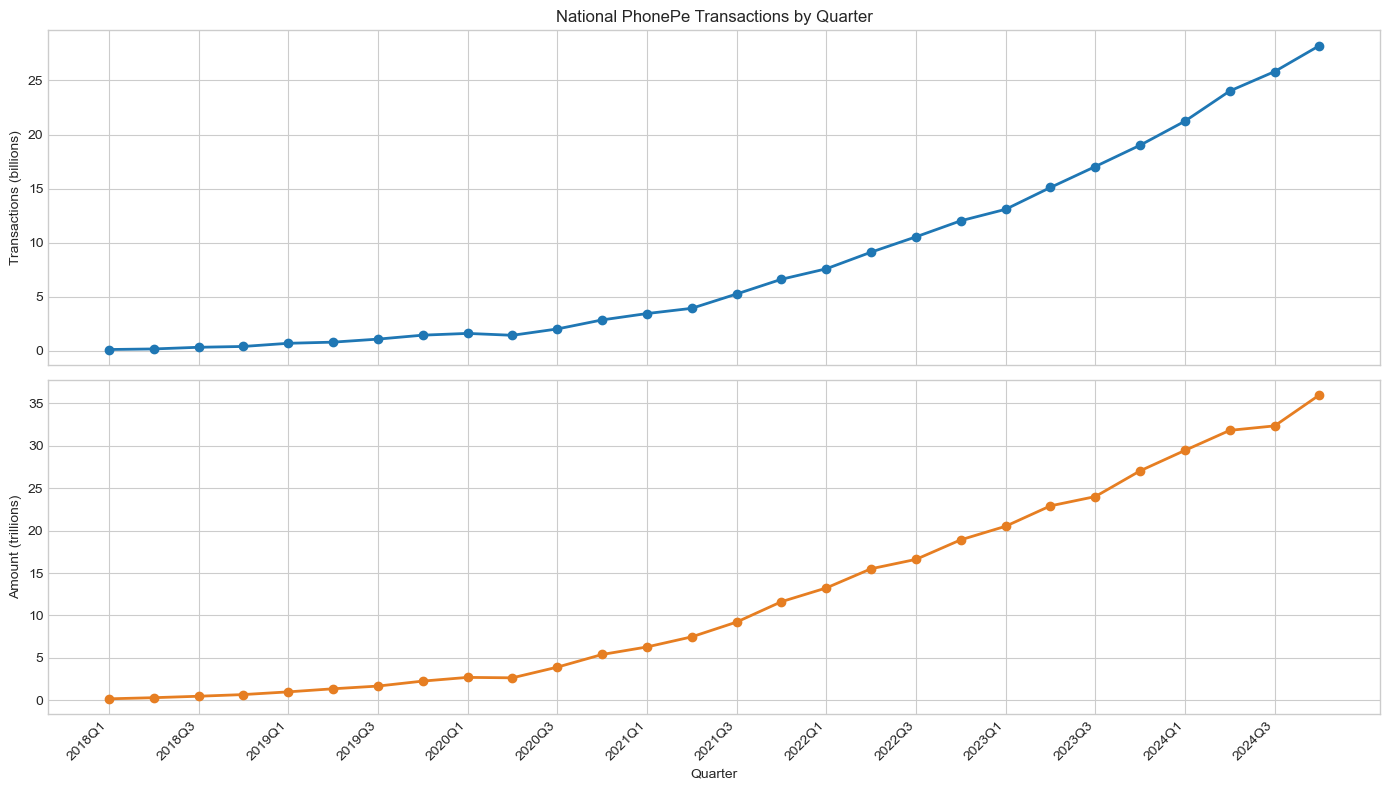

Top 5 quarters by QoQ amount growth (%)


,period,qoq_count_growth_pct,qoq_amount_growth_pct
1,2018Q2,39.3823,77.1333
2,2018Q3,82.1573,56.0912
10,2020Q3,40.3451,47.4618
4,2019Q1,69.9768,47.3825
3,2018Q4,22.2127,41.3879


In [7]:

national_ts = (
    df_txn_state.groupby(["year", "quarter"], as_index=False)
    .agg(total_txn_count=("txn_count", "sum"), total_txn_amount=("txn_amount", "sum"))
    .sort_values(["year", "quarter"])
)

national_ts["period"] = national_ts["year"].astype(str) + "Q" + national_ts["quarter"].astype(str)
national_ts["qoq_count_growth_pct"] = national_ts["total_txn_count"].pct_change() * 100
national_ts["qoq_amount_growth_pct"] = national_ts["total_txn_amount"].pct_change() * 100

display(national_ts.head(3))
display(national_ts.tail(3))

x = np.arange(len(national_ts))
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(x, national_ts["total_txn_count"] / 1e9, marker="o", linewidth=2)
axes[0].set_ylabel("Transactions (billions)")
axes[0].set_title("National PhonePe Transactions by Quarter")

axes[1].plot(x, national_ts["total_txn_amount"] / 1e12, marker="o", linewidth=2, color="#e67e22")
axes[1].set_ylabel("Amount (trillions)")
axes[1].set_xlabel("Quarter")

tick_idx = np.arange(0, len(national_ts), 2)
axes[1].set_xticks(tick_idx)
axes[1].set_xticklabels(national_ts["period"].iloc[tick_idx], rotation=45, ha="right")

plt.tight_layout()
plt.show()

largest_growth = (
    national_ts.dropna(subset=["qoq_amount_growth_pct"])
    .sort_values("qoq_amount_growth_pct", ascending=False)
    [["period", "qoq_count_growth_pct", "qoq_amount_growth_pct"]]
    .head(5)
)

print("Top 5 quarters by QoQ amount growth (%)")
display(largest_growth)

# Cell-level assertions (time-series integrity)
assert len(national_ts) == len(available_yq), "National time series does not span all available quarters."
assert national_ts[["year", "quarter"]].drop_duplicates().shape[0] == len(national_ts)
assert national_ts["total_txn_count"].gt(0).all() and national_ts["total_txn_amount"].gt(0).all()
assert national_ts["qoq_amount_growth_pct"].iloc[1:].notna().all(), "QoQ growth should be defined after the first period."



## D5. EDA: Payment Category Dynamics

**Decision:** Analyze category shares by transaction amount.

**Why:** Relative share is more stable than raw totals for understanding behavior shifts (e.g., merchant vs peer-to-peer mix).


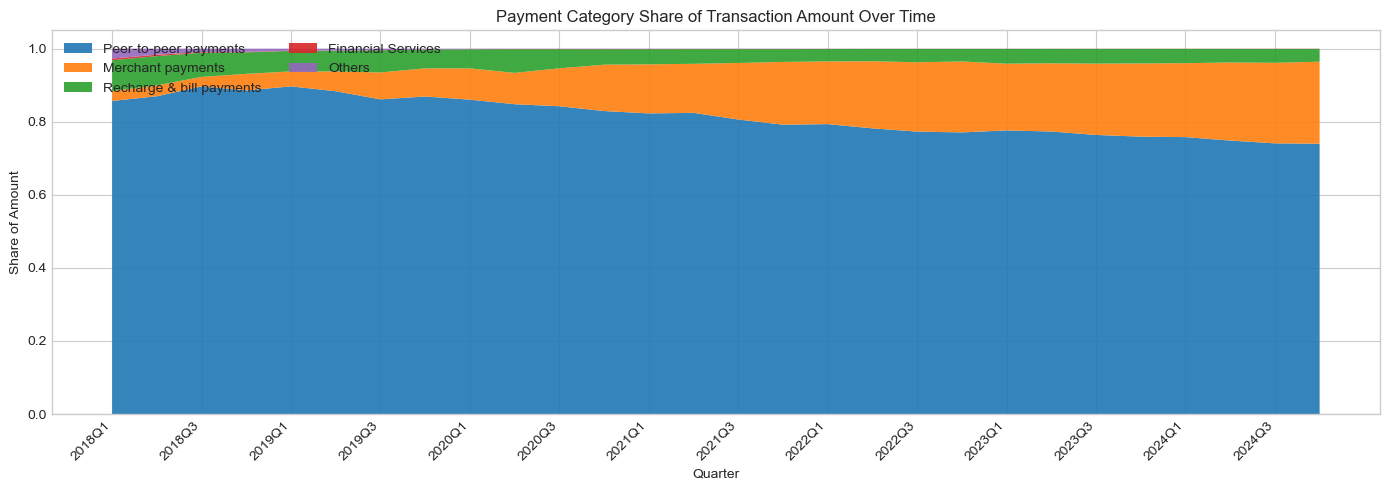

Latest quarter category mix (2024Q4):


,amount_share_pct
category,
Peer-to-peer payments,73.9900
Merchant payments,22.4500
Recharge & bill payments,3.4900
Financial Services,0.0500
Others,0.0300


In [8]:

category_ts = (
    df_agg_category.groupby(["year", "quarter", "category"], as_index=False)
    .agg(total_amount=("txn_amount", "sum"), total_count=("txn_count", "sum"))
    .sort_values(["year", "quarter", "category"])
)
category_ts["period"] = category_ts["year"].astype(str) + "Q" + category_ts["quarter"].astype(str)

category_pivot = category_ts.pivot_table(
    index=["year", "quarter", "period"],
    columns="category",
    values="total_amount",
    aggfunc="sum",
    fill_value=0.0,
).sort_index()

category_share = category_pivot.div(category_pivot.sum(axis=1), axis=0)
ordered_categories = category_share.iloc[-1].sort_values(ascending=False).index.tolist()
category_share = category_share[ordered_categories]

x = np.arange(len(category_share))
fig, ax = plt.subplots(figsize=(14, 5))
ax.stackplot(x, [category_share[c].values for c in category_share.columns], labels=category_share.columns, alpha=0.9)
ax.set_title("Payment Category Share of Transaction Amount Over Time")
ax.set_ylabel("Share of Amount")
ax.set_xlabel("Quarter")

tick_idx = np.arange(0, len(category_share), 2)
ax.set_xticks(tick_idx)
ax.set_xticklabels(category_share.index.get_level_values("period")[tick_idx], rotation=45, ha="right")
ax.legend(loc="upper left", ncol=2)
plt.tight_layout()
plt.show()

latest_category_mix = (category_share.iloc[-1] * 100).round(2).rename("amount_share_pct")
print(f"Latest quarter category mix ({category_share.index[-1][2]}):")
display(latest_category_mix.to_frame())

# Cell-level assertions (category-share integrity)
_row_sums = category_share.sum(axis=1)
assert np.allclose(_row_sums.values, 1.0, atol=1e-9), "Category shares must sum to 1 per quarter."
assert (category_share >= 0).all().all(), "Category shares must be non-negative."
assert 99.9 < float(latest_category_mix.sum()) < 100.1, "Latest category mix should sum to ~100%."



## D6. EDA: Geographic Concentration

**Decision:** Track top-state share and HHI concentration index by quarter.

**Why:** Concentration trends are a practical bias signal; they show whether national totals are dominated by a few regions.


Top 10 states by transaction amount in 2024Q4


,state_name,txn_amount,txn_count,amount_share_pct,count_share_pct
993,karnataka,"4,151,819,803,822.0000","3,455,056,424.0000",11.5332,12.2436
980,maharashtra,"4,151,028,450,887.0000","3,634,231,839.0000",11.5310,12.8786
995,telangana,"3,859,050,535,418.0000","2,822,451,603.0000",10.7199,10.0019
976,andhra pradesh,"3,452,015,568,966.0000","2,296,445,544.0000",9.5893,8.1379
974,uttar pradesh,"3,214,106,522,459.0000","2,544,890,265.0000",8.9284,9.0183
985,rajasthan,"2,793,049,371,408.0000","2,043,469,547.0000",7.7587,7.2414
991,bihar,"2,098,927,476,047.0000","1,559,667,675.0000",5.8305,5.5270
975,madhya pradesh,"2,003,305,068,845.0000","1,685,401,835.0000",5.5649,5.9725
997,west bengal,"1,810,100,029,406.0000","1,227,135,682.0000",5.0282,4.3486
990,odisha,"1,305,457,593,239.0000","1,143,097,568.0000",3.6264,4.0508


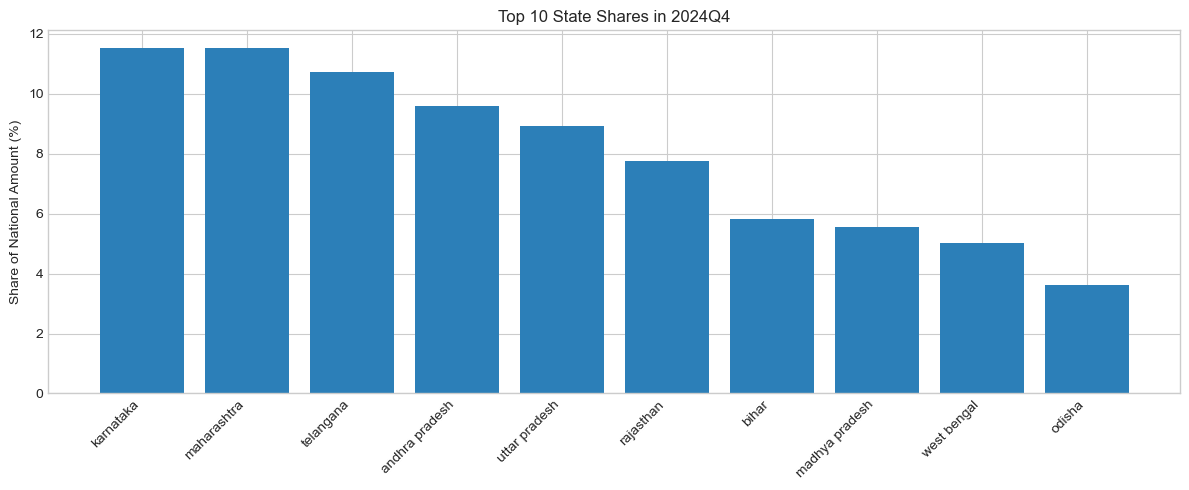

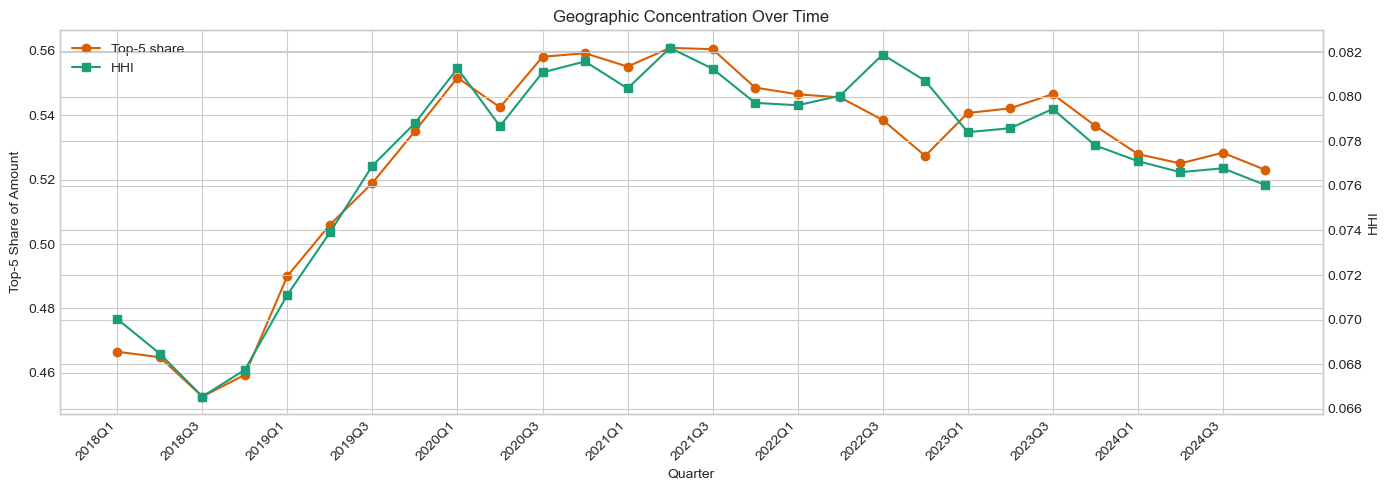

In [9]:

latest_year, latest_quarter = available_yq[-1]
latest_period = quarter_label(latest_year, latest_quarter)

latest_state = df_txn_state.query("year == @latest_year and quarter == @latest_quarter").copy()
latest_state["amount_share_pct"] = 100 * latest_state["txn_amount"] / latest_state["txn_amount"].sum()
latest_state["count_share_pct"] = 100 * latest_state["txn_count"] / latest_state["txn_count"].sum()

latest_top10 = latest_state.nlargest(10, "txn_amount")[
    ["state_name", "txn_amount", "txn_count", "amount_share_pct", "count_share_pct"]
]

print(f"Top 10 states by transaction amount in {latest_period}")
display(latest_top10)

fig, ax = plt.subplots(figsize=(12, 5))
bar_positions = np.arange(len(latest_top10))
ax.bar(bar_positions, latest_top10["amount_share_pct"], color="#2c7fb8")
ax.set_ylabel("Share of National Amount (%)")
ax.set_title(f"Top 10 State Shares in {latest_period}")
ax.set_xticks(bar_positions)
ax.set_xticklabels(latest_top10["state_name"], rotation=45, ha="right")
plt.tight_layout()
plt.show()

concentration_rows = []
for (year, quarter), group in df_txn_state.groupby(["year", "quarter"]):
    shares = group["txn_amount"] / group["txn_amount"].sum()
    concentration_rows.append(
        {
            "year": year,
            "quarter": quarter,
            "period": quarter_label(year, quarter),
            "top5_amount_share": shares.nlargest(5).sum(),
            "hhi_amount": (shares**2).sum(),
        }
    )

concentration_ts = pd.DataFrame(concentration_rows).sort_values(["year", "quarter"]).reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(14, 5))
x = np.arange(len(concentration_ts))
ax1.plot(x, concentration_ts["top5_amount_share"], color="#d95f02", marker="o", label="Top-5 share")
ax1.set_ylabel("Top-5 Share of Amount")
ax1.set_xlabel("Quarter")

ax2 = ax1.twinx()
ax2.plot(x, concentration_ts["hhi_amount"], color="#1b9e77", marker="s", label="HHI")
ax2.set_ylabel("HHI")

ax1.set_title("Geographic Concentration Over Time")
tick_idx = np.arange(0, len(concentration_ts), 2)
ax1.set_xticks(tick_idx)
ax1.set_xticklabels(concentration_ts["period"].iloc[tick_idx], rotation=45, ha="right")

line1, label1 = ax1.get_legend_handles_labels()
line2, label2 = ax2.get_legend_handles_labels()
ax1.legend(line1 + line2, label1 + label2, loc="upper left")
plt.tight_layout()
plt.show()

# Cell-level assertions (concentration metrics)
assert len(latest_top10) == min(10, len(latest_state))
assert concentration_ts["top5_amount_share"].between(0, 1).all(), "Top-5 share must stay in [0,1]."
assert concentration_ts["hhi_amount"].between(0, 1).all(), "HHI must stay in [0,1]."
assert concentration_ts["period"].nunique() == len(available_yq), "Concentration series is missing periods."



## D7. EDA: District Distribution and Sparsity

**Decision:** Inspect district-level distribution in raw and log scale.

**Why:** Payment amounts are highly skewed; log-scale diagnostics reveal structure hidden by extreme values.


District amount quantiles for 2024Q4


,txn_amount
0.1000,"1,348,745,020.8000"
0.2500,"7,551,029,456.2500"
0.5000,"23,470,050,006.5000"
0.7500,"54,427,955,936.2500"
0.9000,"100,698,194,623.9001"
0.9900,"279,278,396,899.4799"


Districts needed to reach 80% of transaction amount in 2024Q4: 270 out of 788


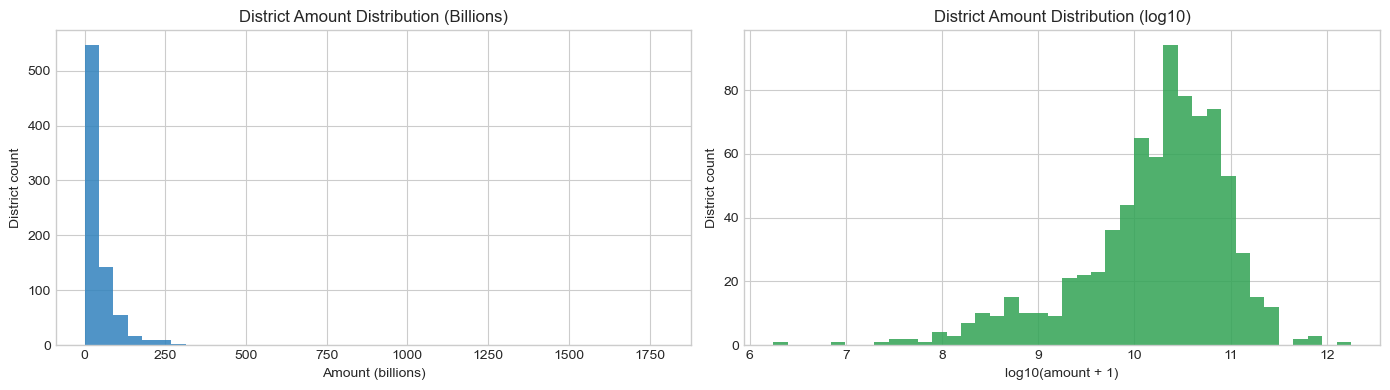

In [10]:

latest_district = df_txn_district.query("year == @latest_year and quarter == @latest_quarter").copy()
latest_district["log10_amount"] = np.log10(latest_district["txn_amount"] + 1)

dist_quantiles = latest_district["txn_amount"].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).rename("txn_amount")
print(f"District amount quantiles for {latest_period}")
display(dist_quantiles.to_frame())

latest_sorted = latest_district.sort_values("txn_amount", ascending=False).reset_index(drop=True)
latest_sorted["cum_share"] = latest_sorted["txn_amount"].cumsum() / latest_sorted["txn_amount"].sum()
districts_for_80 = int((latest_sorted["cum_share"] <= 0.80).sum() + 1)

print(
    f"Districts needed to reach 80% of transaction amount in {latest_period}: "
    f"{districts_for_80} out of {len(latest_sorted)}"
)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(latest_district["txn_amount"] / 1e9, bins=40, color="#3182bd", alpha=0.85)
axes[0].set_title("District Amount Distribution (Billions)")
axes[0].set_xlabel("Amount (billions)")
axes[0].set_ylabel("District count")

axes[1].hist(latest_district["log10_amount"], bins=40, color="#31a354", alpha=0.85)
axes[1].set_title("District Amount Distribution (log10)")
axes[1].set_xlabel("log10(amount + 1)")
axes[1].set_ylabel("District count")

plt.tight_layout()
plt.show()

# Cell-level assertions (district distribution sanity)
assert latest_district["txn_amount"].ge(0).all(), "District transaction amount must be non-negative."
assert dist_quantiles.is_monotonic_increasing, "District quantiles must be monotonic increasing."
assert 1 <= districts_for_80 <= len(latest_sorted), "80%-coverage district count is out of valid range."



## D8. EDA: User-Normalized Activity

**Decision:** Compute district-level `transactions per registered user` and `amount per registered user`.

**Why:** Raw totals conflate market size and activity intensity. Per-user metrics reveal behavior differences that totals miss.


Correlation matrix for user-normalized metrics in 2024Q4


,txns_per_user,amount_per_user,opens_per_user
txns_per_user,1.0000,0.9409,-0.0475
amount_per_user,0.9409,1.0000,-0.0014
opens_per_user,-0.0475,-0.0014,1.0000


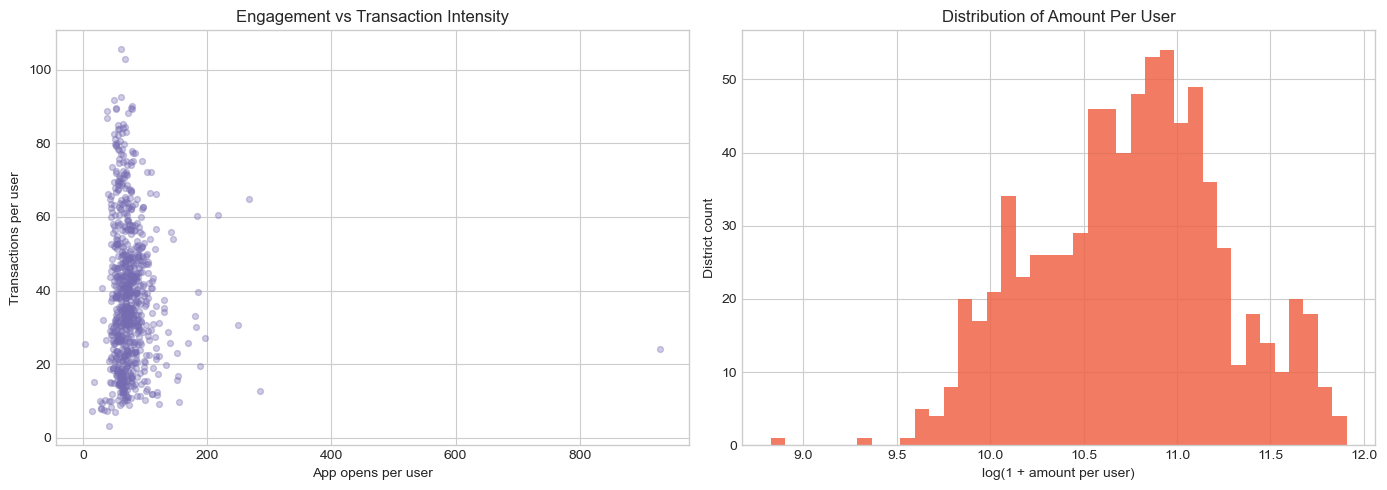

Top 10 states by median district amount per user (2024Q4)


,state_name,district_count,median_txns_per_user,median_amount_per_user,median_opens_per_user
31,telangana,33,79.8090,"124,105.3900",60.4293
1,andhra pradesh,26,73.7886,"113,687.4153",59.2519
15,karnataka,31,63.5081,"88,569.5349",71.0977
28,rajasthan,50,51.0057,"71,628.0976",75.5400
25,odisha,30,55.0900,"66,692.1167",53.9486
4,bihar,38,46.1060,"62,648.1329",79.6917
20,maharashtra,36,47.5348,"59,534.4874",71.9557
14,jharkhand,24,44.8597,"56,137.2822",85.3790
19,madhya pradesh,55,44.2287,"55,000.9153",78.2695
8,delhi,11,48.5593,"54,304.1070",52.3782


Bottom 10 states by median district amount per user (2024Q4)


,state_name,district_count,median_txns_per_user,median_amount_per_user,median_opens_per_user
5,chandigarh,1,25.6906,"28,426.1385",51.6697
26,puducherry,4,23.0800,"27,914.5598",46.6549
27,punjab,23,15.5131,"24,544.5555",65.3861
24,nagaland,16,11.9961,"23,933.5967",59.1530
21,manipur,16,10.0209,"22,035.4968",55.2490
32,tripura,8,14.6633,"21,387.1240",60.4611
18,lakshadweep,1,16.8049,"21,051.6340",152.7593
12,himachal pradesh,12,16.6863,"20,065.7098",55.2630
16,kerala,14,16.1457,"19,811.1985",62.9360
23,mizoram,11,10.3897,"18,084.5686",50.4328


In [11]:

panel_keys = ["state_key", "district_key", "year", "quarter"]

district_panel = df_txn_district.merge(
    df_user_district[panel_keys + ["registered_users", "app_opens"]],
    on=panel_keys,
    how="inner",
)

district_panel["state_name"] = district_panel["state_key"].map(state_name_lookup)
district_panel["txns_per_user"] = district_panel["txn_count"] / district_panel["registered_users"].replace(0, np.nan)
district_panel["amount_per_user"] = district_panel["txn_amount"] / district_panel["registered_users"].replace(0, np.nan)
district_panel["opens_per_user"] = district_panel["app_opens"] / district_panel["registered_users"].replace(0, np.nan)

district_panel = district_panel.replace([np.inf, -np.inf], np.nan)
district_panel = district_panel.dropna(subset=["txns_per_user", "amount_per_user", "opens_per_user"]).copy()

latest_panel = district_panel.query("year == @latest_year and quarter == @latest_quarter").copy()

corr = latest_panel[["txns_per_user", "amount_per_user", "opens_per_user"]].corr()
print(f"Correlation matrix for user-normalized metrics in {latest_period}")
display(corr)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(latest_panel["opens_per_user"], latest_panel["txns_per_user"], alpha=0.35, s=18, color="#756bb1")
axes[0].set_xlabel("App opens per user")
axes[0].set_ylabel("Transactions per user")
axes[0].set_title("Engagement vs Transaction Intensity")

axes[1].hist(np.log1p(latest_panel["amount_per_user"]), bins=40, color="#ef6548", alpha=0.85)
axes[1].set_xlabel("log(1 + amount per user)")
axes[1].set_ylabel("District count")
axes[1].set_title("Distribution of Amount Per User")

plt.tight_layout()
plt.show()

state_intensity = (
    latest_panel.groupby("state_name", as_index=False)
    .agg(
        district_count=("district_name", "nunique"),
        median_txns_per_user=("txns_per_user", "median"),
        median_amount_per_user=("amount_per_user", "median"),
        median_opens_per_user=("opens_per_user", "median"),
    )
    .sort_values("median_amount_per_user", ascending=False)
)

print(f"Top 10 states by median district amount per user ({latest_period})")
display(state_intensity.head(10))
print(f"Bottom 10 states by median district amount per user ({latest_period})")
display(state_intensity.tail(10))

# Cell-level assertions (normalized panel quality)
assert len(district_panel) > 0 and len(latest_panel) > 0
assert np.isfinite(latest_panel[["txns_per_user", "amount_per_user", "opens_per_user"]].to_numpy()).all()
assert (latest_panel[["txns_per_user", "amount_per_user", "opens_per_user"]] >= 0).all().all()
assert corr.shape == (3, 3) and not corr.isna().all().all(), "Correlation matrix should be well-formed and non-empty."



## D9. Bias and Ethical Considerations

Bias can be partially quantified and partially reasoned:

1. **Platform bias:** Data represents PhonePe usage, not all payment activity in India.
2. **Geographic concentration bias:** A few states contribute a large share of volume/value.
3. **Digital-access bias:** Registered users and app-opens differ strongly across districts.
4. **Administrative boundary bias:** Rare district key mismatches likely reflect reporting or boundary changes.
5. **Ethical note:** Analysis is aggregate and anonymized, but interpretations can still impact resource allocation narratives; avoid framing low-activity regions as low potential without contextual factors.


In [12]:
latest_top5_share = float(concentration_ts.iloc[-1]["top5_amount_share"])
latest_hhi = float(concentration_ts.iloc[-1]["hhi_amount"])

p10_amt_user = float(latest_panel["amount_per_user"].quantile(0.10))
p90_amt_user = float(latest_panel["amount_per_user"].quantile(0.90))
ratio_p90_p10 = p90_amt_user / (p10_amt_user + 1e-12)

# Recompute unmatched user-only rows in this subsection for execution-order robustness.
join_keys_bias = ["state_key", "district_key", "year", "quarter"]
user_only_rows = df_user_district.merge(
    df_txn_district[join_keys_bias],
    on=join_keys_bias,
    how="left",
    indicator=True,
)
user_only_rows = user_only_rows[user_only_rows["_merge"] == "left_only"].copy()

bias_metrics = pd.DataFrame(
    [
        {"metric": "Top-5 state share of amount (latest quarter)", "value": latest_top5_share},
        {"metric": "HHI of state amount share (latest quarter)", "value": latest_hhi},
        {"metric": "P90/P10 district amount-per-user ratio (latest quarter)", "value": ratio_p90_p10},
        {"metric": "Unmatched user-only district rows", "value": float(len(user_only_rows))},
    ]
)

display(bias_metrics)

if len(user_only_rows) > 0:
    print("Sample unmatched user-only rows (likely reporting/boundary changes):")
    display(
        user_only_rows[["state_slug", "district_name", "year", "quarter"]]
        .sort_values(["state_slug", "year", "quarter", "district_name"])
        .head(10)
    )

# Cell-level assertions (bias metric sanity)
assert 0 <= latest_top5_share <= 1
assert 0 <= latest_hhi <= 1
assert ratio_p90_p10 >= 1, "P90/P10 ratio should be at least 1."
assert len(bias_metrics) == 4


,metric,value
0,Top-5 state share of amount (latest quarter),0.5230
1,HHI of state amount share (latest quarter),0.0760
2,P90/P10 district amount-per-user ratio (latest...,3.8507
3,Unmatched user-only district rows,4.0000


Sample unmatched user-only rows (likely reporting/boundary changes):


,state_slug,district_name,year,quarter
19,arunachal-pradesh,anjaw district,2018,1
23,arunachal-pradesh,shi yomi district,2018,1
755,arunachal-pradesh,shi yomi district,2018,2
1487,arunachal-pradesh,shi yomi district,2018,3


## D10. Consolidated Assertions for Critical Pipeline Checks

This subsection contains assertion-based checks for critical logic used across D1-D9 (parsing, joins, reconciliation, normalization, and anomaly-sanity), so the checks remain in-notebook and traceable to this section.


In [13]:
# Extended critical checks

for path in required_paths:
    assert path.exists(), f"Missing expected dataset folder: {path}"

assert available_yq, "No year-quarter files found."
assert all(1 <= q <= 4 for _, q in available_yq), "Quarter values out of 1..4."

sample_rows = parse_map_txn_country(*available_yq[0])
assert sample_rows, "Country transaction parser returned no rows for first available quarter."
required_keys = {"state_name", "state_key", "year", "quarter", "txn_count", "txn_amount"}
assert required_keys.issubset(sample_rows[0].keys()), "Parsed row missing required fields."
assert sample_rows[0]["txn_count"] >= 0 and sample_rows[0]["txn_amount"] >= 0

assert normalize_key("Andaman & Nicobar Islands") == "andamannicobarislands"
assert normalize_key("dadra-&-nagar-haveli-&-daman-&-diu") == "dadranagarhavelidamandiu"

for label, df in [
    ("df_txn_state", df_txn_state),
    ("df_user_state", df_user_state),
    ("df_txn_district", df_txn_district),
    ("df_user_district", df_user_district),
    ("df_agg_category", df_agg_category),
]:
    assert len(df) > 0, f"{label} is unexpectedly empty."

join_keys = ["state_key", "district_key", "year", "quarter"]

txn_to_user_ext = df_txn_district.merge(
    df_user_district[join_keys], on=join_keys, how="left", indicator=True
)
match_rate_ext = float((txn_to_user_ext["_merge"] == "both").mean())
assert match_rate_ext >= 0.999, f"District transaction->user match rate too low: {match_rate_ext:.4%}"

user_only_rows_ext = df_user_district.merge(
    df_txn_district[join_keys], on=join_keys, how="left", indicator=True
)
user_only_rows_ext = user_only_rows_ext[user_only_rows_ext["_merge"] == "left_only"].copy()
assert len(user_only_rows_ext) <= 10, f"Too many unmatched user-only district rows: {len(user_only_rows_ext)}"

panel_ext = df_txn_district.merge(
    df_user_district[join_keys + ["registered_users", "app_opens"]],
    on=join_keys,
    how="inner",
)
panel_ext["txns_per_user"] = panel_ext["txn_count"] / panel_ext["registered_users"].replace(0, np.nan)
panel_ext["amount_per_user"] = panel_ext["txn_amount"] / panel_ext["registered_users"].replace(0, np.nan)
panel_ext["opens_per_user"] = panel_ext["app_opens"] / panel_ext["registered_users"].replace(0, np.nan)
panel_ext = panel_ext.replace([np.inf, -np.inf], np.nan)
panel_ext = panel_ext.dropna(subset=["txns_per_user", "amount_per_user", "opens_per_user"]).copy()
assert len(panel_ext) > 0, "Normalized district panel is empty after filtering."

panel_ext["log_amount_per_user"] = np.log1p(panel_ext["amount_per_user"])
quarter_stats_ext = (
    panel_ext.groupby(["year", "quarter"])["log_amount_per_user"]
    .agg(
        median_log="median",
        mad_log=lambda s: np.median(np.abs(s - np.median(s))),
    )
    .reset_index()
)

panel_ext = panel_ext.merge(quarter_stats_ext, on=["year", "quarter"], how="left")
panel_ext["robust_z_amount_per_user"] = (
    0.6745 * (panel_ext["log_amount_per_user"] - panel_ext["median_log"]) / (panel_ext["mad_log"] + 1e-9)
)

assert np.isfinite(panel_ext["robust_z_amount_per_user"]).all(), "Robust z-score contains non-finite values."
outlier_rate_ext = float((panel_ext["robust_z_amount_per_user"].abs() >= 3).mean())
assert 0.0 < outlier_rate_ext < 0.2, f"Unexpected anomaly outlier rate: {outlier_rate_ext:.2%}"

print("Extended critical assertions passed.")
print(f"- district_match_rate: {match_rate_ext:.4%}")
print(f"- user_only_rows: {len(user_only_rows_ext)}")
print(f"- anomaly_outlier_rate: {outlier_rate_ext:.4%}")


Extended critical assertions passed.
- district_match_rate: 100.0000%
- user_only_rows: 4
- anomaly_outlier_rate: 1.6841%



# E. Initial Insights and Direction

This section converts EDA outputs into concrete, testable project direction.


In [14]:

panel_for_anomaly = district_panel.copy()
panel_for_anomaly["log_amount_per_user"] = np.log1p(panel_for_anomaly["amount_per_user"])

quarter_stats = (
    panel_for_anomaly.groupby(["year", "quarter"])["log_amount_per_user"]
    .agg(
        median_log="median",
        mad_log=lambda s: np.median(np.abs(s - np.median(s))),
    )
    .reset_index()
)

panel_for_anomaly = panel_for_anomaly.merge(quarter_stats, on=["year", "quarter"], how="left")
panel_for_anomaly["robust_z_amount_per_user"] = (
    0.6745 * (panel_for_anomaly["log_amount_per_user"] - panel_for_anomaly["median_log"])
    / (panel_for_anomaly["mad_log"] + 1e-9)
)

outliers = panel_for_anomaly[panel_for_anomaly["robust_z_amount_per_user"].abs() >= 3].copy()
outliers["period"] = outliers["year"].astype(str) + "Q" + outliers["quarter"].astype(str)
outlier_rate = len(outliers) / len(panel_for_anomaly)

first_merchant_share = float(category_share.iloc[0].get("Merchant payments", np.nan))
latest_merchant_share = float(category_share.iloc[-1].get("Merchant payments", np.nan))
merchant_delta_pp = (latest_merchant_share - first_merchant_share) * 100
merchant_direction = "increased" if merchant_delta_pp >= 0 else "decreased"

first_top5 = float(concentration_ts.iloc[0]["top5_amount_share"])
latest_top5 = float(concentration_ts.iloc[-1]["top5_amount_share"])
top5_delta_pp = (latest_top5 - first_top5) * 100

insights = pd.DataFrame(
    [
        {
            "observation": "Merchant payments gained share over time",
            "evidence": (
                f"Merchant share {merchant_direction} by {abs(merchant_delta_pp):.2f} percentage points "
                f"from {quarter_label(*available_yq[0])} to {quarter_label(*available_yq[-1])}."
            ),
            "why_it_matters": "Category mix shift suggests structural behavior change, not just growth in baseline volume.",
        },
        {
            "observation": "State concentration remains substantial",
            "evidence": (
                f"Top-5 state amount share moved from {first_top5:.3f} to {latest_top5:.3f} "
                f"({top5_delta_pp:+.2f} percentage points)."
            ),
            "why_it_matters": "Model evaluation should include fairness/robustness checks across high- and low-volume regions.",
        },
        {
            "observation": "District-level intensity dispersion is large",
            "evidence": (
                f"Latest-quarter P90/P10 amount-per-user ratio = {ratio_p90_p10:.2f}."
            ),
            "why_it_matters": "Single global thresholds can miss region-specific patterns; stratified analysis is justified.",
        },
        {
            "observation": "Anomaly baseline flags a non-trivial tail",
            "evidence": (
                f"|robust_z| >= 3 for {len(outliers):,} of {len(panel_for_anomaly):,} district-quarter rows "
                f"({100*outlier_rate:.2f}%)."
            ),
            "why_it_matters": "Supports anomaly detection as a course-aligned modeling track with measurable signal.",
        },
    ]
)

display(insights)

print("Top anomaly candidates (by absolute robust z-score):")
display(
    outliers.assign(abs_z=outliers["robust_z_amount_per_user"].abs())
    .sort_values("abs_z", ascending=False)
    [["period", "state_name", "district_name", "amount_per_user", "robust_z_amount_per_user"]]
    .head(12)
)

# Cell-level assertions (insight inputs)
assert np.isfinite(panel_for_anomaly["robust_z_amount_per_user"]).all(), "Robust z-score contains non-finite values."
assert 0 < outlier_rate < 0.2, f"Unexpected outlier rate: {outlier_rate:.2%}"
assert not np.isnan(first_merchant_share) and not np.isnan(latest_merchant_share), "Merchant share values missing."
assert len(outliers) > 0, "Expected non-empty anomaly candidate set."


,observation,evidence,why_it_matters
0,Merchant payments gained share over time,Merchant share increased by 19.74 percentage p...,Category mix shift suggests structural behavio...
1,State concentration remains substantial,Top-5 state amount share moved from 0.467 to 0...,Model evaluation should include fairness/robus...
2,District-level intensity dispersion is large,Latest-quarter P90/P10 amount-per-user ratio =...,Single global thresholds can miss region-speci...
3,Anomaly baseline flags a non-trivial tail,"|robust_z| >= 3 for 347 of 20,604 district-qua...",Supports anomaly detection as a course-aligned...


Top anomaly candidates (by absolute robust z-score):


,period,state_name,district_name,amount_per_user,robust_z_amount_per_user
30,2018Q1,arunachal pradesh,dibang valley district,2.5741,-24.9705
755,2018Q2,arunachal pradesh,anjaw district,19.1976,-17.7289
1145,2018Q2,manipur,pherzawl district,27.2724,-16.5931
414,2018Q1,manipur,pherzawl district,32.4204,-16.5875
233,2018Q1,jammu & kashmir,poonch district,"200,520.0627",16.0358
964,2018Q2,jammu & kashmir,poonch district,"392,068.4317",15.6158
2427,2018Q4,jammu & kashmir,poonch district,"349,824.9165",15.1292
1695,2018Q3,jammu & kashmir,poonch district,"335,265.5096",13.3617
3159,2019Q1,jammu & kashmir,poonch district,"249,352.8809",12.3384
5361,2019Q4,jammu & kashmir,kulgam district,50.8727,-12.2788



## Proposed Next-Step Research Questions

**Course-aligned track (anomaly detection / clustering):**
1. Which districts are persistent outliers in user-normalized transaction behavior after controlling for quarter-level shifts?
2. Do clusters based on (`txns_per_user`, `amount_per_user`, `opens_per_user`, category mix) reveal stable behavioral archetypes?

**Beyond-course track (additional technique):**
1. Apply **Bayesian or offline change-point detection** on state-level quarterly series to identify structural breaks in payment behavior.
2. Compare change-point timings against category-share shifts (especially merchant vs peer-to-peer) to test whether breaks reflect composition change.

These questions are directly motivated by the EDA above and keep the project technically feasible with the current data scale.



# F. GitHub Portfolio Building

- **Public repository link:** https://github.com/ShashankC10/phonePePulseEDA

## Collaboration Declaration (Checkpoint Notebook)

1. **Collaborators:** None (individual work), unless updated by student.
2. **Web Sources:**
   - PhonePe Pulse repository and documentation: https://github.com/PhonePe/pulse
   - Instacart Market Basket Analysis challenge data page: https://www.kaggle.com/c/instacart-market-basket-analysis/data
   - KDD 2025 Datasets & Benchmarks track page: https://kdd2025.kdd.org/datasets-and-benchmarks-track-papers-2/
3. **AI Tools:** OpenAI Codex (for coding assistance, validation scaffolding).
4. **Paper Citations:**
   - None used directly for quantitative claims in this checkpoint notebook.
